# Synthetic data for learning the AR automatically
This notebook is to test whether the LSTM-RL model can learn the process error of AR as well as the phi_AR.

In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

from tqdm import tqdm
from datetime import datetime, timedelta
from src.RL_functions.generate_synthetic_time_series import *
from examples.data_loader import TimeSeriesDataloader
from pytagi import Normalizer as normalizer
from pytagi.nn import LSTM, Linear, OutputUpdater, Sequential
from pytagi.hybrid import LSTM_SSM
from pytagi.hybrid import process_input_ssm
import pytagi.metric as metric

## Generate synthetic time series with Kernel regression

In [2]:
components = ['acceleration', 'kernel', 'ar']
hyperparameters = {'acceleration': {'process_error_var': 0.0, 'constant_LA_process_error': 0.0 },
                   'kernel': {'period': 52, 'kernel_length': 0.5, 'sigma_KR0': 0, 'sigma_KR1': 0, 'n_cp':10},
                   'ar': {'phi': 0.9, 'process_error_var': 0.2**2},
                #    'ar': {'phi': 0.75, 'process_error_var': 0**2},
                   'observation': {'error': 1e-20}}
x_init = {'mu': np.array([0.294, 0.001, 0, 0, -0.35, -0.25, 1.90, 2.81, -0.03, 0.30, -0.35, 1.70, 0.10, -0.15, -0.05]), \
          'var': np.diag([1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 6.36E-05])}

# components = ['level', 'ar']
# hyperparameters = {'level': {'process_error_var': 0.0, 'constant_LA_process_error': 0.0 },
#                    'ar': {'phi': 0.75, 'process_error_var': 4**2},
#                 #    'ar': {'phi': 0.75, 'process_error_var': 0**2},
#                    'observation': {'error': 1e-20}}
# # x_init = {'mu': np.array([0.294, 0.00027, 0, -0.05]), \
# #           'var': np.diag([1E-15, 1E-15, 1E-15, 6.36E-05])}
# x_init = {'mu': np.array([4, -0.05]), \
#           'var': np.diag([1E-15, 6.36E-05])}


total_time_steps = int(52*5)
time_step_interval = 7
np.random.seed(2024)
syn_ts = generate_time_series(components = components,\
                                      time_step = time_step_interval, \
                                      hyperparameters = hyperparameters,\
                                      num_steps = total_time_steps, \
                                      x_init = x_init,\
                                      insert_anomaly = False)

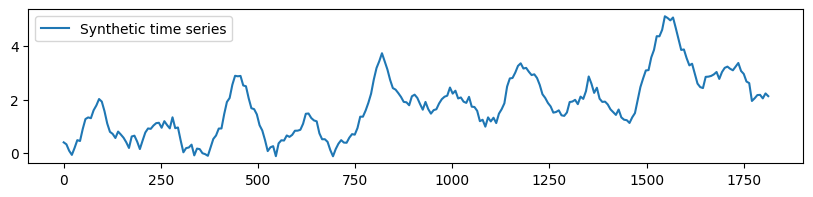

In [3]:
from matplotlib import gridspec
fig = plt.figure(figsize=(10, 2))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])

ax0.plot(syn_ts['timesteps'], syn_ts['y'], label='Synthetic time series', alpha=1)
ax0.legend()

### Export the generated data to csv
For the compatibility with LSTM

In [4]:
# Export data to csv file
training_idx = int(0.8 * total_time_steps) - 1
test_idx = total_time_steps - 1

start_datetime = datetime(2005, 11, 6, 12, 0, 0)  # Start datetime
datetime_values = generate_datetime_values(start_datetime, len(syn_ts['timesteps']), time_step_interval)

# # Training set generation
train_observations = syn_ts['y'][0: training_idx]
train_datetime_values = datetime_values[0: training_idx]

# Test set generation
test_observations = syn_ts['y'][training_idx-26:]
test_datetime_values = datetime_values[training_idx-26:]

# Save training csv files
with open('data/synthetic_ts/syn_train_obs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['syn_obs'])
    for i in range(len(train_datetime_values)):
        writer.writerow([round(float(train_observations[i]), 3)])
with open('data/synthetic_ts/syn_train_datetime.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['date_time'])
    for i in range(len(train_datetime_values)):
        writer.writerow([train_datetime_values[i]])

# Save test csv files
with open('data/synthetic_ts/syn_test_obs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['syn_obs'])
    for i in range(len(test_datetime_values)):
        writer.writerow([round(float(test_observations[i]), 3)])
with open('data/synthetic_ts/syn_test_datetime.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['date_time'])
    for i in range(len(test_datetime_values)):
        writer.writerow([test_datetime_values[i]])

## Train BDLM
The components are AA + AR + LSTM. The AR component here learns automatically the phi_AR and sigma_AR

### Configuration

In [5]:
num_epochs: int = 50
batch_size: int = 1
sigma_v: float = 1E-12

"""Run training for time-series forecasting model"""
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

train_dtl = TimeSeriesDataloader(
    x_file="data/synthetic_ts/syn_train_obs.csv",
    date_time_file="data/synthetic_ts/syn_train_datetime.csv",
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
)
test_dtl = TimeSeriesDataloader(
    x_file="data/synthetic_ts/syn_test_obs.csv",
    date_time_file="data/synthetic_ts/syn_test_datetime.csv",
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    x_mean=train_dtl.x_mean,
    x_std=train_dtl.x_std,
    time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
)

In [6]:
x_data = np.array(pd.read_csv("data/synthetic_ts/syn_train_obs.csv", skiprows=1, delimiter=",", header=None).values.T[0])
x_data = normalizer.standardize(data=x_data, mu=train_dtl.x_mean[output_col], std=train_dtl.x_std[output_col])
time_idx = np.arange(0, len(x_data))

# Fit a first-order regression model, ax+b, to the data x_data, y_data
valid_indices = ~np.isnan(x_data)
time_idx_filtered = time_idx[valid_indices]
x_data_filtered = x_data[valid_indices]
speed_init, level_init = np.polyfit(time_idx_filtered, x_data_filtered, 1)

print(f"Initial level: {level_init}, Initial speed: {speed_init}")

Initial level: -0.9162102464982715, Initial speed: 0.008895245111633704


In [7]:
print((0.294 - train_dtl.x_mean[output_col])/train_dtl.x_std[output_col])

[-1.70804378]


### Compare the true baseline and the baseline estimated by the first-order regression

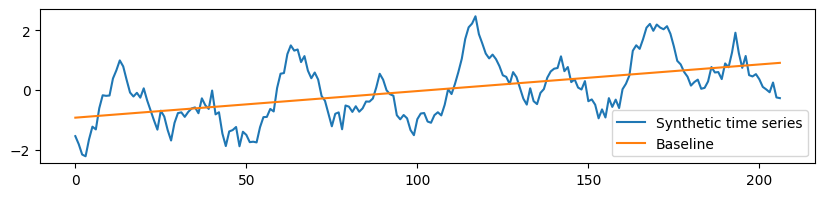

In [8]:
# Plot x_data
fig = plt.figure(figsize=(10, 2))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ax0.plot(time_idx, x_data, label='Synthetic time series', alpha=1)
# Plot baseline with initial level and speed
baseline = level_init + speed_init * time_idx
ax0.plot(time_idx, baseline, label='Baseline', alpha=1)
ax0.legend()

### Training

In [9]:
# Network
net = Sequential(
    LSTM(num_features, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net.set_threads(8)
# #net.to_device("cuda")

# # # State-space models: for baseline hidden states
phi_AA = 0.999
Sigma_AR = 0.15**2
Sigma_AA = Sigma_AR*1e-17
LA_var_stationary = Sigma_AA/(1-phi_AA**2)
# # Autoregressive acceleration + online AR
hybrid = LSTM_SSM(
    neural_network = net,           # LSTM
    baseline = 'AA + AR', # 'level', 'trend', 'acceleration', 'ETS'
    zB  = np.array([level_init, speed_init, 0, 0.5, -0.05]),    # First-order-regression baseline
    SzB = np.array([1E-16, 1E-10, LA_var_stationary, 0.5**2, 0.15**2]),    # var
    phi_AA = phi_AA,
    Sigma_AA = Sigma_AA,
    use_auto_AR = True,
    mu_W2b_init = 1**2,
    var_W2b_init = 1**2,
)

# Training
mses = []

pbar = tqdm(range(num_epochs), desc="Training Progress")
for epoch in pbar:
    batch_iter = train_dtl.create_data_loader(batch_size, shuffle=False)

    # Decaying observation's variance
    # sigma_v = exponential_scheduler(
    #     curr_v=1E-12, min_v=1E-12, decaying_factor=1, curr_iter=epoch
    # )
    sigma_v = sigma_v
    var_y = np.full((batch_size * len(output_col),), sigma_v**2, dtype=np.float32)

    # Initialize list to save
    hybrid.init_ssm_hs()
    mu_preds_lstm = []
    var_preds_lstm = []
    mu_preds_unnorm = []
    obs_unnorm = []
    mu_phiar = []
    var_phiar = []
    # mu_aa = []
    # var_aa = []
    mu_sigma_ar = []
    var_sigma_ar = []

    for x, y in batch_iter:
        mu_x, var_x = process_input_ssm(
            mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
            input_seq_len = input_seq_len, num_features = num_features,
            )

        # Feed forward
        y_pred, _, z_pred, Sz_pred, m_pred, v_pred = hybrid(mu_x, var_x)
        # Backward
        hybrid.backward(mu_obs = y, var_obs = var_y)

        # Training metric
        pred = normalizer.unstandardize(
            y_pred.flatten(), train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        )
        obs = normalizer.unstandardize(
            y, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        )
        mse = metric.mse(pred, obs)
        mses.append(mse)
        mu_preds_lstm.extend(m_pred)
        var_preds_lstm.extend(v_pred)
        obs_unnorm.extend(y)
        mu_preds_unnorm.extend(y_pred)
        mu_phiar.append(z_pred[-3].item())
        var_phiar.append(Sz_pred[-3][-3])
        # mu_aa.append(z_pred[2].item())
        # var_aa.append(Sz_pred[2][2])
        mu_sigma_ar.append(np.sqrt(hybrid.mu_W2b_posterior.item()))
        var_sigma_ar.append(np.sqrt(hybrid.var_W2b_posterior.item()))

    # Smoother
    hybrid.smoother()

    mu_smoothed = np.array(hybrid.mu_smoothed)
    cov_smoothed = np.array(hybrid.cov_smoothed)

    # Figures for each epoch
    plt.switch_backend('Agg')
    plt.figure()
    plt.plot(obs_unnorm, color='r',label=r"obs.")
    plt.plot(mu_smoothed[:,0,:],color='k',label=r"level")
    plt.fill_between(np.arange(len(mu_smoothed[:,0,:])), np.array(mu_smoothed[:,0,:]).flatten() - np.sqrt(cov_smoothed[:, 0, 0]), np.array(mu_smoothed[:,0,:]).flatten() + np.sqrt(cov_smoothed[:, 0, 0]), color='k', alpha=0.3, label='_nolegend_')
    plt.plot(mu_smoothed[:,-2,:],color='g',label=r"AR")
    plt.fill_between(np.arange(len(mu_smoothed[:,-2,:])), np.array(mu_smoothed[:,-2,:]).flatten() - np.sqrt(cov_smoothed[:, -2, -2]), np.array(mu_smoothed[:,-2,:]).flatten() + np.sqrt(cov_smoothed[:, -2, -2]), color='g', alpha=0.3, label='_nolegend_')
    plt.plot(mu_preds_unnorm,color='b',label=r"pred.")
    plt.plot(mu_smoothed[:,-1,:],color='orange',label=r"LSTM")
    plt.fill_between(np.arange(len(mu_smoothed[:,-1,:])), np.array(mu_smoothed[:,-1,:]).flatten() - np.sqrt(cov_smoothed[:, -1, -1]), np.array(mu_smoothed[:,-1,:]).flatten() + np.sqrt(cov_smoothed[:, -1, -1]), color='orange', alpha=0.3, label='_nolegend_')
    plt.legend(ncol = 3, loc='upper left')
    filename = f'saved_results/syn_autoAR/hybrid_epoch_#{epoch}.png'
    plt.savefig(filename)
    plt.close()  # Close the plot to free up memory

    # figure for phi_AR
    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(2, 1)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax0.plot(np.arange(len(mu_phiar)),mu_phiar,color='b',label=r"AR")
    ax0.fill_between(np.arange(len(mu_phiar)), np.array(mu_phiar) - np.sqrt(var_phiar), np.array(mu_phiar) + np.sqrt(var_phiar), color='blue', alpha=0.3, label='±1 SD')
    ax0.axhline(y=hyperparameters['ar']['phi'], color='r', linestyle='--', label='True phi')
    ax0.set_ylim(-0.1, 1.1)
    ax0.set_ylabel('phi_AR')
    ax1.plot(np.arange(len(mu_sigma_ar)),mu_sigma_ar,color='b',label=r"AR")
    ax1.fill_between(np.arange(len(mu_sigma_ar)), np.array(mu_sigma_ar) - np.sqrt(var_sigma_ar), np.array(mu_sigma_ar) + np.sqrt(var_sigma_ar), color='blue', alpha=0.3, label='±1 SD')
    ax1.axhline(y=np.sqrt(hyperparameters['ar']['process_error_var']) / (train_dtl.x_std[output_col] + 1e-10),
                color='r', linestyle='--', label='True sigma_AR')
    ax1.set_ylabel('sigma_AR')
    filename = f'saved_results/syn_autoAR/AR_epoch_#{epoch}.png'
    plt.savefig(filename)
    plt.close()  # Close the plot to free up memory

    # Progress bar
    pbar.set_description(
        f"Epoch {epoch + 1}/{num_epochs}| mse: {np.nanmean(mses):>7.2f}",
        refresh=True,
    )

# print the value of AR
print(f"phi_AR: {mu_phiar[-1]}")

# -------------------------------------------------------------------------#
# Testing
test_batch_iter = test_dtl.create_data_loader(batch_size, shuffle=False)

# Initialize list to save
mu_preds = []
var_preds = []
y_test = []
obs_test_unnorm = []
#

for x, y in test_batch_iter:
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
        input_seq_len = input_seq_len,num_features = num_features,
    )
    # Feed forward
    y_pred, Sy_red, z_pred, Sz_pred, m_pred, v_pred = hybrid(mu_x, var_x)
    hybrid.backward(mu_obs = np.nan, var_obs = np.nan, train_LSTM=False)

    mu_preds.extend(y_pred)
    var_preds.extend(Sy_red + sigma_v**2)
    y_test.extend(y)
    mu_preds_lstm.extend(m_pred)
    var_preds_lstm.extend(v_pred)

mu_preds = np.array(mu_preds)
std_preds = np.array(var_preds) ** 0.5
y_test = np.array(y_test)
obs_test_unnorm = y_test
mu_preds_unnorm_test = mu_preds
std_preds_unnorm_test = std_preds

mu_preds = normalizer.unstandardize(
    mu_preds, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
)
std_preds = normalizer.unstandardize_std(std_preds, train_dtl.x_std[output_col])

y_test = normalizer.unstandardize(
    y_test, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
)

# Compute log-likelihood
mse = metric.mse(mu_preds, y_test)
log_lik = metric.log_likelihood(
    prediction=mu_preds, observation=y_test, std=std_preds
)

#
obs = np.concatenate((obs_unnorm,obs_test_unnorm), axis=0)
idx_train = range(0,len(obs_unnorm))

idx_test = range(len(obs_unnorm),len(obs))
idx = np.concatenate((idx_train,idx_test),axis=0)
mu_preds_unnorm_test = mu_preds_unnorm_test.flatten()
std_preds_unnorm_test = std_preds_unnorm_test.flatten()

# figure for final test predictions
plt.figure()
plt.plot(idx,obs, color='r',label=r"data")
plt.plot(idx_test, mu_preds_unnorm_test, color='b',label=r"test prediction")
plt.fill_between(idx_test, mu_preds_unnorm_test - std_preds_unnorm_test, mu_preds_unnorm_test + std_preds_unnorm_test, color='blue', alpha=0.3, label='±1 SD')
plt.plot(idx_train,mu_smoothed[:,0,:],color='k',label=r"level")
plt.plot(idx_train, mu_preds_unnorm,color='g', label=r"train prediction")
filename = f'saved_results/syn_autoAR/test_prediction1.png'
plt.savefig(filename)
plt.close()  # Close the plot to free up memory

print("#############")
print(f"MSE           : {mse: 0.2f}")
print(f"Log-likelihood: {log_lik: 0.2f}")

Epoch 50/50| mse:    0.04: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


phi_AR: 0.37540956617668525
#############
MSE           :  0.87
Log-likelihood: -12.21


In [10]:
print(std_preds_unnorm_test)

[0.23526894 0.24687526 0.24961106 0.25119298 0.2517974  0.2520625
 0.25207824 0.25225192 0.25200182 0.25229215 0.25284206 0.2526768
 0.25300031 0.25324267 0.25377173 0.25383325 0.25448504 0.25493193
 0.25474422 0.25362131 0.25354089 0.25288946 0.25196165 0.25071712
 0.2500943  0.24944845 0.24750243 0.24444762 0.24245635 0.24058903
 0.2403424  0.2400181  0.23970884 0.23940736 0.23940667 0.23956915
 0.23957602 0.23975911 0.23966843 0.23942975 0.23925728 0.23914362
 0.23912527 0.23911684 0.23929401 0.23958225 0.23995394 0.24064941
 0.24165883 0.24287063 0.24416128 0.2454466  0.24674607]
